# Platinum Preferred Structure
1. For the following, we consider three possible structures for platinum: simple cubic, hexagonal closed packed (hcp), and face center cubic (fcc). 
2. For each case we calculate energy values for a variety of lattice constants $a$ to determine the $a$ that minimizes $E$. 

In [44]:
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Simple Cubic 
We can start with simple cubic 

### Functions for automating Quantum Espresso calls
1. Below we define a few (crude) functions that help us create our input file for quantum espresso. 
2. Then we loop over different values for the cut off energy, calculate the total energy, and parse the qe output file to store values in a python array for plotting. 

In [60]:
def file_name(element_name):
    if (type(element_name) != str):
        return "Error: Please enter a valid element name string"
    return element_name + '.scf.in' 


def control(file_object, prefix, pseudo_dir = '.', outdir = '.'):
    
    # prefix line 
    file_object.write('&control\n')
    prefix_line = '    prefix = ' + "'" + prefix + "',"
    file_object.write(prefix_line + "\n")
    
    # pseudo dir line 
    pseudo_dir_line = '    pseudo_dir = ' + "'" + pseudo_dir + "',"
    file_object.write(pseudo_dir_line + "\n")
    
    # 
    outdir_line = '    outdir = ' + "'" + outdir + "',"
    file_object.write(outdir_line + "\n" + '/')
    file_object.write('\n')    
    
    
def system(file_object, ibrav, celldm_num, celldm, nat, ntyp, metal = 'no', ecutwfc = 20.0, celldm3 = 0.0):
    # system
    file_object.write('&system\n')
    file_object.write('    ibrav = ' + str(ibrav) + ',\n')
    file_object.write('    celldm(' + str(celldm_num) + ') = ' + str(celldm) + ',\n')
    if celldm3 != 0.0:
        file_object.write('    celldm(3) =' + str(celldm3) + ',\n')
    file_object.write('    nat = ' + str(nat) + ',\n')
    file_object.write('    ntyp = ' + str(ntyp) + ',\n')
    
    if (metal == 'yes'):
        file_object.write('    occupations = ' + " 'smearing', " + '\n')
        file_object.write('    smearing = ' + "'mp'," + 'degauss = 0.06,\n')
    
    file_object.write('    ecutwfc = ' + str(ecutwfc) + ',\n')
    
    file_object.write('/' + '\n')
    

def electrons(file_object):
    file_object.write('&electrons\n')
    file_object.write('/' + '\n')
    
    
def atomic_species(file_object, species, mass, pseudo_pot):
    """ extend functionality later """
    file_object.write('ATOMIC_SPECIES\n')
    file_object.write(' ' + species)
    file_object.write(' ' + str(mass))
    file_object.write(' ' + pseudo_pot + '\n')
    

def atomic_positions(file_object, dicti, coordinate = ''):
    """ need to link to ase later 
        accepts a dict: {species: location}
    """
    file_object.write('ATOMIC_POSITIONS (' + coordinate + ')\n')
    for species in dicti:
        file_object.write(" " + dicti[species] + "\n")
        

def k_points(file_object, k_point, offset = 0):
    file_object.write('K_POINTS automatic\n')
    k_point = str(k_point)
    if (offset == 0):
        file_object.write(' ' + k_point + ' ' + k_point + ' ' + k_point + ' 0 0 0' + "\n")
    else:
        file_object.write(' ' + k_point + ' ' + k_point + ' ' + k_point + ' 1 1 1' + "\n")
    

def parse_output(outfile):
    """ Parses the quantum espresso output file """
    
    with open(outfile, 'r') as outf:
        for line in outf:
            if (line.lower().startswith('     lattice parameter (alat)')):
                lattice_constant = float(line.split()[-2]) * 0.529177
            if (line.lower().startswith('!    total energy')):
                total_energy = float(line.split()[-2]) * 13.605698066
    
    result = {'energy': total_energy, 'lattice': lattice_constant}
    return result 

In [17]:
struct = {
    'atom1' : 'cu 0.00 0.00 0.00', 
}

In [30]:
def ge_file_write(element_name, struct, alat):
    """ function to generate input file """
    name = file_name('cu')
    f = open(name, 'w')
    
    control(f, element_name, '/Users/vinhtran/Documents/GitHub/DFT/Energy-Lattice-Constant/Copper',\
               '/Users/vinhtran/Documents/GitHub/DFT/Energy-Lattice-Constant/Copper')
    system(f, ibrav = 2, celldm_num = 1, celldm = alat, nat = 1, ntyp = 1, metal = 'yes', ecutwfc = 40.0)
    electrons(f)
    atomic_species(f, 'cu', 63.546, 'Cu_pbe_v1.2.uspp.F.UPF')
    atomic_positions(f, struct)
    k_points(f, 8)

    f.close()
    return name 

In [31]:
lattice_array = np.linspace(6.4, 7.2, 8) #bohr 

In [52]:
total_energy_sc = np.zeros(len(lattice_array))

for i in range(len(lattice_array)): 
    # Remove existing files 
    subprocess.run(["rm", "cu.scf.in", "cu.scf.out"])
    # generate input file 
    name = ge_file_write('Copper', struct, lattice_array[i])
    # call qe calculation in shell 
    subprocess.run('pw.x -in cu.scf.in > cu.scf.out', shell=True);
    # parse output file and store values in result dict 
    result = parse_output('cu.scf.out')
    # getting the energy back 
    total_energy_sc[i] = result['energy']

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floatin

In [53]:
total_energy_sc 

array([-29.67573647, -29.676489  , -29.67697879, -29.67724933,
       -29.67733986, -29.67728258, -29.67710495, -29.6768294 ])

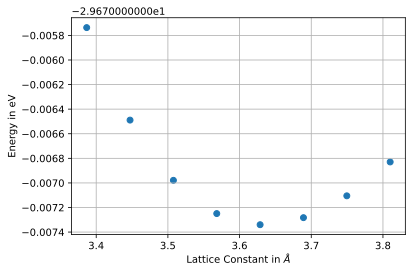

In [55]:
fig = plt.scatter(lattice_array*0.529177, total_energy_sc)
#plt.ticklabel_format(axis = 'both', style = 'plain', useOffset=None)
plt.grid()
plt.xlabel('Lattice Constant in $\AA$')
plt.ylabel('Energy in eV')
plt.show()
#plt.title('Copper FCC: Energy/atom vs Lattice Constant a')

# Hexagonal Closed Pack 
Next, we can consider HCP

In [57]:
struct_hcp = {
    'atom1' : 'cu  0.00 0.00 0.00', 
    'atom2' : 'cu  0.333333333  0.333333333  0.333333333'
}

In [61]:
def ge_file_write_hcp(element_name, struct, alat):
    """ function to generate input file """
    name = file_name('cu')
    f = open(name, 'w')
    
    control(f, element_name, '/Users/vinhtran/Documents/GitHub/DFT/Energy-Lattice-Constant/Copper',\
               '/Users/vinhtran/Documents/GitHub/DFT/Energy-Lattice-Constant/Copper')
    system(f, ibrav = 4, celldm_num = 1, celldm = alat, nat = 2, ntyp = 1,\
           metal = 'yes', ecutwfc = 30.0, celldm3 = 1.633)
    electrons(f)
    atomic_species(f, 'cu', 63.546, 'Cu_pbe_v1.2.uspp.F.UPF')
    atomic_positions(f, struct, 'crystal')
    k_points(f, 6)

    f.close()
    return name 

In [62]:
total_energy_hcp = np.zeros(len(lattice_array))

for i in range(len(lattice_array)): 
    # Remove existing files 
    subprocess.run(["rm", "cu.scf.in", "cu.scf.out"])
    # generate input file 
    name = ge_file_write_hcp('Copper', struct_hcp, lattice_array[i])
    # call qe calculation in shell 
    subprocess.run('pw.x -in cu.scf.in > cu.scf.out', shell=True);
    # parse output file and store values in result dict 
    result = parse_output('cu.scf.out')
    # getting the energy back 
    total_energy_hcp[i] = result['energy']

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floatin

Text(0.5, 1.0, 'Platinum SC: Energy/atom vs Lattice Constant a')

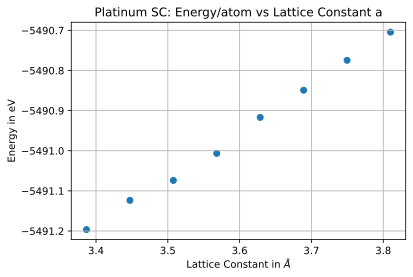

In [63]:
plt.scatter(lattice_array*0.529177, total_energy_hcp/2)
#plt.scatter(lattice_array*0.529177, total_energy_sc)
plt.grid()
plt.xlabel('Lattice Constant in $\AA$')
plt.ylabel('Energy in eV')
plt.title('Platinum SC: Energy/atom vs Lattice Constant a')

# Face Center Cubic

In [81]:
struct_fcc = {
    'atom1' : 'Pt  0.00  0.00  0.00'
}

In [82]:
def ge_file_write_fcc(element_name, struct, alat):
    """ function to generate input file """
    name = file_name('Pt')
    f = open(name, 'w')
    
    control(f, element_name, '/Users/vinhtran/Documents/GitHub/DFT/Energy-Lattice-Constant/Platinum',\
               '/Users/vinhtran/Documents/GitHub/DFT/Energy-Lattice-Constant/Platinum')
    system(f, ibrav = 2, celldm_num = 1, celldm = alat, nat = 1, ntyp = 1,\
           metal = 'yes', ecutwfc = 20.0)
    electrons(f)
    atomic_species(f, 'Pt', 195.084, 'pt_pbe_v1.4.uspp.F.UPF')
    atomic_positions(f, struct)
    k_points(f, 6, offset = 1.0)

    f.close()
    return name 

In [89]:
lattice_array_fcc = np.linspace(4.4, 11.4, 10)

In [90]:
total_energy_fcc = np.zeros(len(lattice_array_fcc))

for i in range(len(lattice_array_fcc)): 
    # Remove existing files 
    subprocess.run(["rm", "Pt.scf.in", "pt.scf.out"])
    # generate input file 
    name = ge_file_write_fcc('Platinum', struct_fcc, lattice_array_fcc[i])
    # call qe calculation in shell 
    subprocess.run('pw.x -in Pt.scf.in > pt.scf.out', shell=True);
    # parse output file and store values in result dict 
    result = parse_output('pt.scf.out')
    # getting the energy back 
    total_energy_fcc[i] = result['energy']

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floatin

## Plotting everything back together

Text(0.5, 1.0, 'Platinum FCC: Energy/atom vs Lattice Constant a')

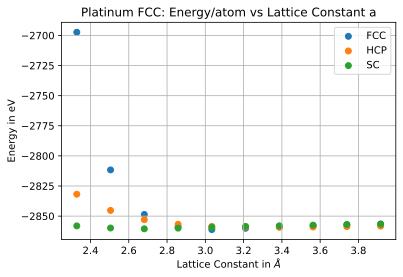

In [95]:
plt.scatter(lattice_array*0.529177, total_energy_fcc, label = 'FCC')
plt.scatter(lattice_array*0.529177, total_energy_hcp/2, label = 'HCP')
plt.scatter(lattice_array*0.529177, total_energy_sc, label = 'SC')
plt.legend()

plt.grid()
plt.xlabel('Lattice Constant in $\AA$')
plt.ylabel('Energy in eV')
plt.title('Platinum FCC: Energy/atom vs Lattice Constant a')